In [16]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from skimage import io
from scipy import ndimage as ndi
from skimage import feature
from skimage.filters import gaussian
from skimage.filters import sobel
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
from skimage.exposure import rescale_intensity
from skimage.feature import canny
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import remove_small_objects  


### Function to load the input file

In [7]:
def input_file(file_name):
    ''' To load the imput file as an array.
    Args:
        file_name (string) : Name of the file to be loaded as it is 
        saved on the disk. Provide file path if it is not in
        the same directory as the jupyter notebook.
    Returns:
        In case of a video, returns an array for each frame
        in the video.
        In case of an image, return an array.    
    '''
    frames = io.imread(file_name)
    return frames

In [8]:
frames = input_file('../doc/PPA_Melting_6_14_19.tiff')

### Function to flip the frames horizontally and vertically to correct for the mirroring during recording

In [13]:
def flip_frame(frames):
    ''' To flip all the loaded frames horizontally and vertically
        to correct for the mirroring during recording.
        Args:
        frames(Array): An array containing an array for each frame
        in the video or just a single array in case of an image.
        Returns:
        Flipped frames that can be processed to get temperature data.
    '''
    flip_frames = []
    for frame in frames:
        f_frame = np.fliplr(frame)
        flip_frames.append(np.flipud(f_frame))
    return flip_frames

In [14]:
flip_frames = flip_frame(frames)

In [15]:
len(flip_frames)

1619

### Function to detect edges, fill and label the holes.

In [20]:
def edge_detection(flip_frames):
    ''' To detect the edges of the wells, fill and label them to
    determine their centroids.
    Args:
    flip_frames: The frames to be processed and determine the
    sample temperature from.
    Returns:
    
    '''
    
    edges = feature.canny(flip_frames[0]/1500)
    filled_wells = binary_fill_holes(edges)
    cl_wells = remove_small_objects(filled_wells,min_size = 20)
    labeled_wells = label(cl_wells)
    return labeled_wells

In [21]:
labeled_wells = edge_detection(flip_frames)

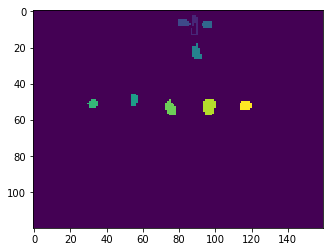

In [22]:
plt.imshow(labeled_wells)

### Function to determine centroids of all the samples

In [107]:
def regprop(labeled_wells,flip_frames):
    ''' Determines the area and centroid of all samples.
        Args:
        labeled_wells(array): An array with labeled samples.
        flip_frames (array) : Original intensity image to determine
        the intensity at sample centroids.
        Returns:
        A dataframe with information about samples.
    '''
    regprops = {} 
    for i in range(len(flip_frames)):
        props = regionprops(labeled_wells, intensity_image=flip_frames[i])
        x = np.zeros(len(props)).astype(int)
        y = np.zeros(len(props)).astype(int)
        area = np.zeros(len(props))
        perim = np.zeros(len(props))
        intensity = np.zeros(len(props),dtype=np.float64)
        plate = np.zeros(len(props),dtype=np.float64)
        plate_coord = np.zeros(len(props))
       
        c = 0
        for prop in props:
            x[c] = int(prop.centroid[0])
            y[c] = int(prop.centroid[1])
            #print(y[c])
            area[c] = prop.area
            perim[c] = prop.perimeter
            intensity[c] = flip_frames[i][x[c]][y[c]]
            plate[c] = flip_frames[i][x[c]][y[c]+10]
            plate_coord[c] = y[c]+10
            c = c + 1
            
        regprops[i] = pd.DataFrame({'X': x, 'Y': y,'Plate':plate,'Plate_coord':plate_coord ,'Area': area,
                                'Perim': perim, 'Mean Intensity': intensity},dtype=np.float64)
    return regprops

In [108]:
regprops = regprop(labeled_wells,flip_frames)

In [109]:
regprops[0]

,X,Y,Plate,Plate_coord,Area,Perim,Mean Intensity
0,8.0,88.0,29673.0,98.0,26.0,21.414214,29654.0
1,6.0,82.0,29572.0,92.0,24.0,16.242641,29814.0
2,7.0,95.0,29553.0,105.0,22.0,14.828427,29780.0
3,22.0,89.0,29489.0,99.0,31.0,19.035534,29641.0
4,48.0,55.0,29476.0,65.0,25.0,16.828427,29332.0
5,51.0,32.0,29465.0,42.0,23.0,15.071068,29308.0
6,53.0,75.0,29534.0,85.0,38.0,21.485281,29329.0
7,52.0,96.0,29472.0,106.0,54.0,25.071068,29303.0
8,52.0,116.0,29513.0,126.0,32.0,18.242641,29336.0


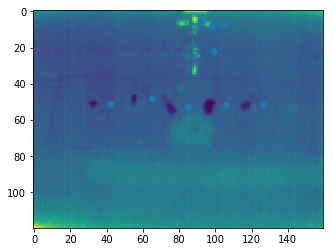

In [110]:
plt.imshow(flip_frames[0])
plt.scatter(regprops[0]['Plate_coord'],regprops[0]['X'])

In [46]:
for i in range(len(flip_frames)):
    if len(regprops[i]) != 9:
        print('Wrong number of samples')
        print(i)

### Function to obtain temperature of samples and plate temp

In [121]:
def sample_temp(regprops,flip_frames):
    temp = []
    plate_temp = []
    for j in range(len(regprops[1])):
        temp_well = []
        plate_well_temp = []
        for i in range(len(flip_frames)):
            temp_well.append(regprops[i]['Mean Intensity'][j])
            plate_well_temp.append(regprops[i]['Plate'][j])
        temp.append(temp_well)
        plate_temp.append(plate_well_temp)
    return temp,plate_temp

In [117]:
temp, plate_temp = sample_temp(regprops,flip_frames)